---
title: Informes Cambio de Componentes
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources import *
from io import BytesIO
import pdfplumber
from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import Readr
from kdags.resources.ggplot import *
from kdags.resources.tidyr import *

import matplotlib.pyplot as plt
import numpy as np

# from itables import init_notebook_mode, show

# init_notebook_mode(all_interactive=True)

context = dg.build_asset_context()


def generate_weekly_summary(df):

    weekly_summary = df.group_by("changeout_week").agg(
        pl.col("changeout_date").count().alias("total"),
        (~pl.col("has_report")).cast(pl.Int64).sum().alias("missing"),
    )

    # Calculate percentages and available counts
    weekly_summary = weekly_summary.with_columns(
        (pl.col("missing") / pl.col("total") * 100)
        .round(1)
        .alias("missing_percentage"),
        (pl.col("total") - pl.col("missing")).alias("available"),
    )

    # Sort by week to ensure chronological order
    weekly_summary = weekly_summary.sort("changeout_week", descending=True)

    # Filter to weeks with at least one record
    weekly_summary = weekly_summary.filter(pl.col("total") > 0)

    return weekly_summary


def plot_icc_report(weekly_summary):
    """
    Create the ICC report visualization using GGPrism.

    Parameters:
        weekly_summary (pd.DataFrame): Weekly summary from generate_weekly_summary function

    Returns:
        tuple: (fig, ax) - Matplotlib figure and axis objects
    """
    # Create theme and figure
    theme = GGPrism()
    fig, ax = theme.create_figure(figsize=(12, 7))

    # Plot stacked bars
    x = np.arange(len(weekly_summary))
    ax.bar(
        x,
        weekly_summary["available"],
        width=0.85,
        color=theme.COLORS[0],
        label="Available",
        edgecolor="white",
        linewidth=0.8,
    )
    ax.bar(
        x,
        weekly_summary["missing"],
        width=0.85,
        bottom=weekly_summary["available"],
        color=theme.COLORS[4],
        label="Missing",
        edgecolor="white",
        linewidth=0.8,
    )

    # Add percentage labels with improved positioning
    for i, row in enumerate(weekly_summary.itertuples()):
        # Adjust vertical position based on total value to prevent overlap
        vertical_offset = 0.3  # Base offset

        # Add more space for higher bars to prevent label overlap
        if row.total >= 5:
            vertical_offset = 0.4

        if row.missing > 0:
            ax.text(
                i,
                row.total + vertical_offset,
                f"{int(row.missing_percentage)}%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )
        else:
            ax.text(
                i,
                row.total + vertical_offset,
                "0%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(weekly_summary["week"], rotation=90)

    # Ensure y-axis has enough room for labels
    y_max = max(weekly_summary["total"]) + 1.5  # Add extra space for labels
    ax.set_ylim(0, y_max)

    # Apply styling and finalize plot
    theme.style_legend(ax, title="Report Status", loc="upper right")
    theme.finalize_plot(
        fig,
        ax,
        title="Weekly ICC Reports Status",
        xlabel="Week",
        ylabel="Number of Reports",
    )

    return fig


# result = kdefs.get_job_def("icc_job").execute_in_process(raise_on_error=True)

In [2]:
icc_df = (
    Readr.Reliability.read_icc()
    .with_columns(
        has_report=pl.col("report_date").is_not_null(),
        changeout_week=pl.col("changeout_date").dt.strftime("%Y-W%V"),
    )
    .sort("changeout_date", descending=True)
)
cc_df = Readr.Planning.read_cc().sort("changeout_date", descending=True)
weekly_summary_df = generate_weekly_summary(icc_df)

In [3]:
weekly_summary_df

changeout_week,total,missing,missing_percentage,available
str,u32,i64,f64,i64
"""2025-W12""",2,1,50.0,1
"""2025-W10""",2,2,100.0,0
"""2025-W09""",3,2,66.7,1
"""2025-W08""",1,0,0.0,1
"""2025-W07""",2,2,100.0,0
…,…,…,…,…
"""2024-W42""",1,0,0.0,1
"""2024-W41""",1,0,0.0,1
"""2024-W40""",2,0,0.0,2


(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Weekly ICC Reports Status'}, xlabel='Week', ylabel='Number of Reports'>)

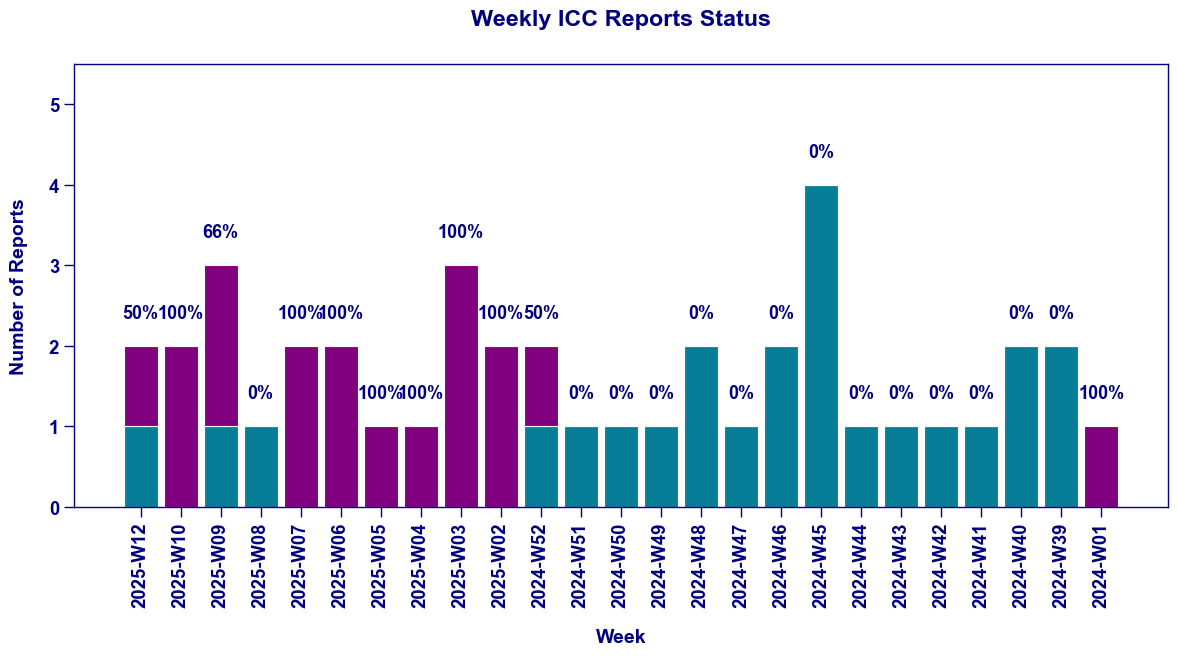

In [8]:
from kdags.resources.ggplot.core import GGPrism
from kdags.resources.ggplot.basic_plots import bar_plot


def plot_icc_report_alternative(weekly_summary):
    """
    Alternative implementation using the bar_plot function from basic_plots.
    """
    # Create theme instance
    theme = GGPrism()

    # Make sure we're working with a Polars DataFrame
    if not isinstance(weekly_summary, pl.DataFrame):
        weekly_summary = pl.from_pandas(weekly_summary)

    # Create a stacked bar plot
    fig, ax = bar_plot(
        theme=theme,
        df=weekly_summary,
        x="changeout_week",
        y=["available", "missing"],
        figsize=(12, 7),
        stacked=True,
        width=0.85,
    )

    # Get data as numpy arrays for custom annotations
    total = weekly_summary.select("total").to_numpy().flatten()
    missing_percentage = (
        weekly_summary.select("missing_percentage").to_numpy().flatten()
    )

    # Add percentage labels
    for i in range(len(weekly_summary)):
        vertical_offset = 0.3 if total[i] < 5 else 0.4
        percentage_text = (
            f"{int(missing_percentage[i])}%" if missing_percentage[i] > 0 else "0%"
        )

        ax.text(
            i,
            total[i] + vertical_offset,
            percentage_text,
            ha="center",
            va="bottom",
            fontsize=13,
            fontweight="bold",
            color=theme.FIXED_COLORS["axis_color"],
        )

    # Set x-tick rotation
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Ensure y-axis has enough room for labels
    y_max = max(total) + 1.5
    ax.set_ylim(0, y_max)

    # Finalize plot
    theme.finalize_plot(
        fig,
        ax,
        title="Weekly ICC Reports Status",
        xlabel="Week",
        ylabel="Number of Reports",
        legend_title="Report Status",
    )

    return fig, ax


plot_icc_report_alternative(weekly_summary_df)

In [9]:
icc_df

equipment_name,equipment_hours,equipment_hours_icc,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,file_type,failure_description,has_report,changeout_week
str,i64,f64,str,str,str,i64,datetime[μs],date,i64,str,str,str,bool,str
null,null,20.65,null,null,null,null,2024-11-13 00:00:00,null,null,"""ICC TK285 ST2 2024-11-12""","""pdf""",null,true,null
null,null,26.067,null,null,null,null,2024-10-08 00:00:00,null,null,"""ICC TK291 BP2 2024-10-03""","""pdf""",null,true,null
null,null,27.365,null,null,null,null,2024-12-31 00:00:00,null,null,"""ICC TK291 CL2 2024-12-24""","""pdf""",null,true,null
null,null,26.645,null,null,null,null,2024-11-08 00:00:00,null,null,"""ICC TK291 CL1 2024-11-07""","""pdf""",null,true,null
null,null,88.089,null,null,null,null,2024-10-26 00:00:00,null,null,"""ICC TK322 CL2 2024-10-25""","""pdf""",null,true,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""TK847""",75291,75.292,"""conjunto_masa_suspension""","""CMS""","""izquierdo""",1,2024-10-17 00:00:00,2024-10-11,18129328,"""ICC TK847 CMS1 2024-10-11""","""pdf""","""Se procede a cambio de suspens…",true,"""2024-W41"""
"""TK863""",60401,60.401,"""conjunto_masa_suspension""","""CMS""","""izquierdo""",1,2024-10-08 00:00:00,2024-10-06,18129275,"""ICC TK863 CMS1 2024-10-06""","""pdf""","""Se procede a cambio de suspens…",true,"""2024-W40"""
"""TK322""",87842,87.842,"""modulo_potencia""","""MP""","""unico""",0,2024-10-08 00:00:00,2024-10-03,18129431,"""ICC TK322 MP 2024-10-03""","""pdf""","""Se procede a cambio de modulo …",true,"""2024-W40"""


In [27]:
icc_df.filter(
    pl.col("filename").str.contains("TK285")
    # & (pl.col("component_name") == "suspension_trasera")
)

equipment_name,equipment_hours,equipment_hours_icc,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,file_type,failure_description,has_report,changeout_week
str,i64,f64,str,str,str,i64,datetime[μs],date,i64,str,str,str,bool,str
null,null,20.65,null,null,null,null,2024-11-13 00:00:00,null,null,"""ICC TK285 ST2 2024-11-12""","""pdf""",null,true,null


In [26]:
cc_df.filter(
    (pl.col("equipment_name") == "TK285")
    & (pl.col("component_name") == "suspension_trasera")
)  # ICC TK285 ST2 2024-11-12

cc_index,equipment_name,equipment_model,position_name,changeout_date,equipment_hours,component_hours,tbo,component_usage,failure_description,removed_component_serial,installed_component_serial,customer_work_order,site_name,component_name,subcomponent_name
u32,str,str,str,date,f64,str,str,str,str,str,str,i64,str,str,str
2844,"""TK285""","""930E-4""","""derecho""",2024-11-12,20650.0,"""20650""","""30000""","""0.688333333""","""Se procede a cambio de suspens…","""#0167""","""#325""",18129920,"""MEL""","""suspension_trasera""","""suspension_trasera"""


(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Weekly ICC Reports Status'}, xlabel='Week', ylabel='Number of Reports'>)

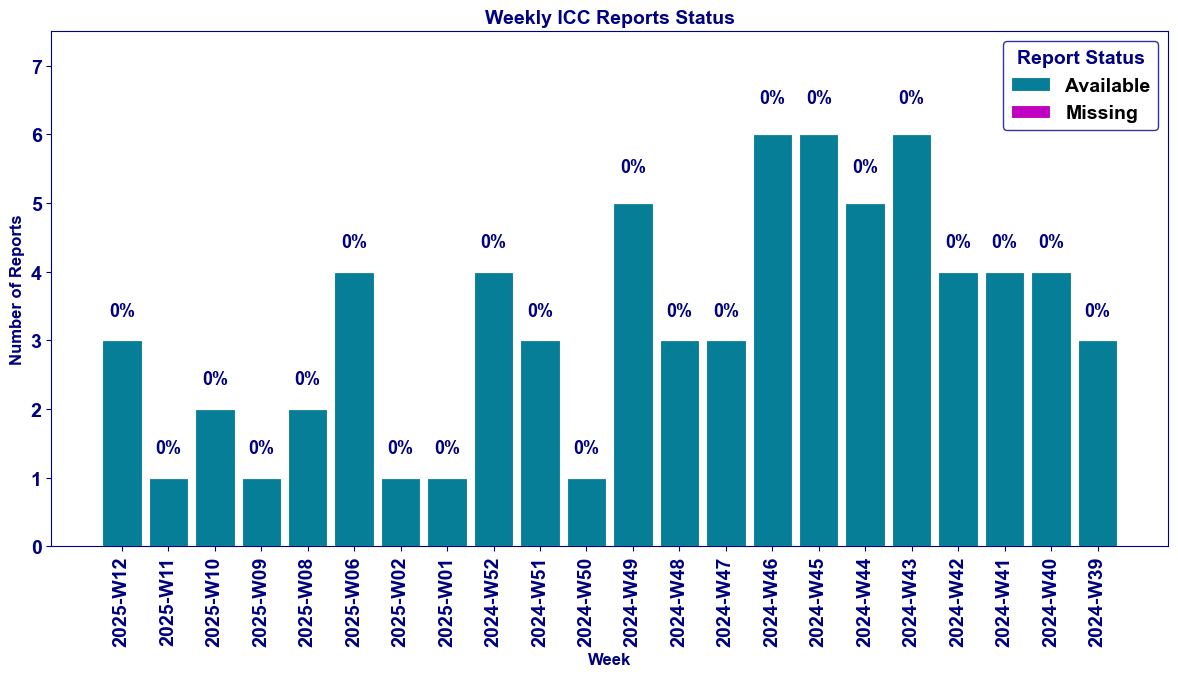

In [17]:
from kdags.resources.ggplot import core as ggprism


def plot_icc_report(weekly_summary):
    """
    Create the ICC report visualization with winter bright theme.

    Parameters:
        weekly_summary (pd.DataFrame): Weekly summary DataFrame

    Returns:
        tuple: (fig, ax) - Matplotlib figure and axis objects
    """
    # Create figure with theme
    fig, ax = ggprism.create_figure(figsize=(12, 7))

    # Get data as numpy arrays
    x = np.arange(len(weekly_summary))
    available = weekly_summary["available"].values
    missing = weekly_summary["missing"].values
    total = weekly_summary["total"].values
    missing_percentage = weekly_summary["missing_percentage"].values

    # Plot stacked bars
    ax.bar(
        x,
        available,
        width=0.85,
        color=ggprism.COLORS[0],
        label="Available",
        edgecolor="white",
        linewidth=0.8,
    )
    ax.bar(
        x,
        missing,
        width=0.85,
        bottom=available,
        color=ggprism.COLORS[4],
        label="Missing",
        edgecolor="white",
        linewidth=0.8,
    )

    # Add percentage labels
    for i, row in enumerate(weekly_summary.itertuples()):
        vertical_offset = 0.3
        if row.total >= 5:
            vertical_offset = 0.4

        percentage_text = f"{int(row.missing_percentage)}%" if row.missing > 0 else "0%"
        ax.text(
            i,
            row.total + vertical_offset,
            percentage_text,
            ha="center",
            va="bottom",
            fontsize=13,
            fontweight="bold",
            color=ggprism.AXIS_COLOR,
        )

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(weekly_summary["changeout_week"], rotation=90)

    # Set y-axis limit
    y_max = max(total) + 1.5
    ax.set_ylim(0, y_max)

    # Set labels and title
    ax.set_title(
        "Weekly ICC Reports Status",
        color=ggprism.AXIS_COLOR,
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xlabel("Week", color=ggprism.AXIS_COLOR, fontsize=12, fontweight="bold")
    ax.set_ylabel(
        "Number of Reports", color=ggprism.AXIS_COLOR, fontsize=12, fontweight="bold"
    )

    # Style legend
    ggprism.style_legend(ax, title="Report Status", loc="upper right")

    # Apply tight layout
    plt.tight_layout()

    return fig, ax


plot_icc_report(weekly_summary_df.to_pandas())

In [3]:
weekly_summary_df = generate_weekly_summary(icc_df)
weekly_summary_df

changeout_week,total,missing,missing_percentage,available
str,u32,u32,f64,u32
"""2025-W13""",1,1,100.0,0
"""2025-W12""",5,2,40.0,3
"""2025-W11""",3,2,66.7,1
"""2025-W10""",6,5,83.3,1
"""2025-W09""",4,4,100.0,0
…,…,…,…,…
"""2024-W42""",4,0,0.0,4
"""2024-W41""",4,0,0.0,4
"""2024-W40""",6,1,16.7,5


In [9]:
icc_df.filter(pl.col("changeout_date").is_null())

equipment_name,equipment_hours_icc,equipment_hours_plan,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,failure_description,has_report,changeout_week
str,f64,i64,str,str,str,i64,datetime[μs],date,i64,str,str,bool,str
null,56.772,null,null,"""877 CMS 02 01-02-25""",null,0,2025-02-05 00:00:00,null,null,"""ICC 877 CMS 02 01-02-25""",null,true,null


## Cantidad de reportes faltantes por semana

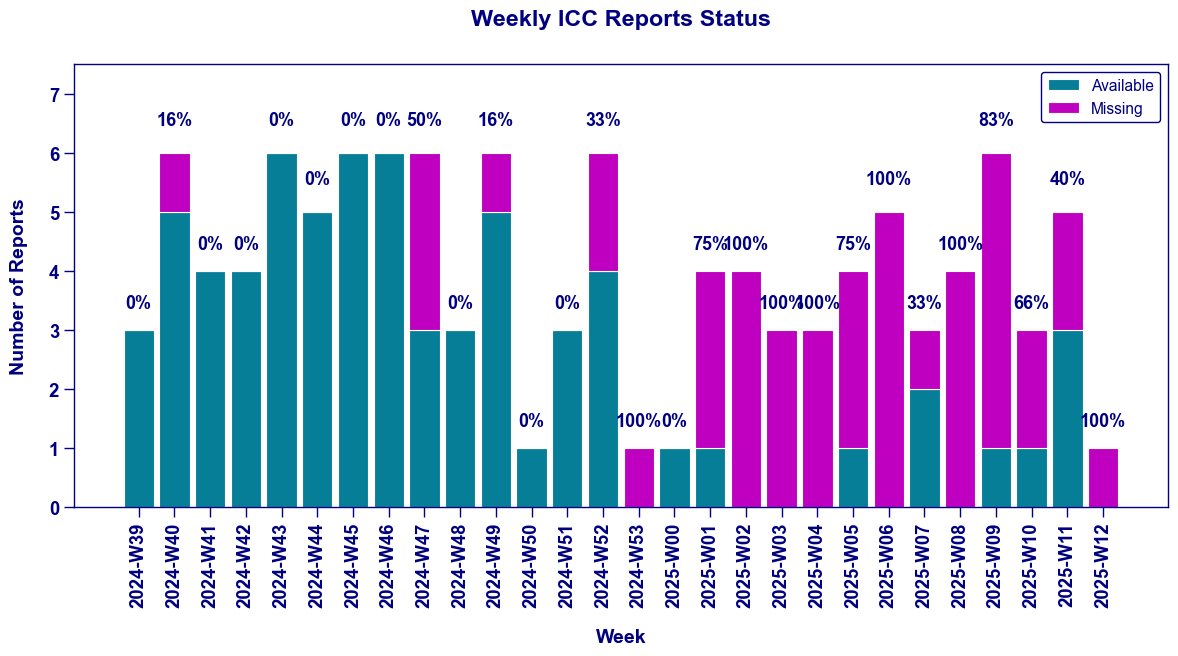

In [6]:
df = clean_icc_data(icc_df)
weekly_summary = generate_weekly_summary(df)
fig = plot_icc_report(weekly_summary)

In [10]:
df.sort_values("changeout_date", ascending=False)

,equipment_name,equipment_hours_icc,equipment_hours_plan,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,failure_description,__index_level_0__,has_report,week
111,TK865,NaN,65074.0,suspension_trasera,ST,izquierdo,1,NaT,2025-03-24,-1.0,None,Se procede a cambio de suspensión Trasera izqu...,75,False,2025-W12
110,TK881,51831.000,51831.0,suspension_trasera,ST,derecho,2,2025-03-25,2025-03-23,-1.0,ICC TK881 ST2 2025-03-23,Se procede a cambio de suspensión Trasera dere...,115,True,2025-W11
109,TK881,51831.000,51831.0,cilindro_direccion,CD,izquierdo,1,2025-03-25,2025-03-23,-1.0,ICC TK881 CD1 2025-03-23,Se programa cambio de cilindro de dirección Iz...,111,True,2025-W11
108,TK291,26798.000,28788.0,motor_traccion,MT,derecho,2,2025-03-25,2025-03-22,-1.0,ICC TK291 MT2 2025-03-22,Se procede a cambio Mt2 por presentar particul...,9,True,2025-W11
107,TK851,NaN,76377.0,cilindro_direccion,CD,derecho,2,NaT,2025-03-20,-1.0,None,Se programa cambio de cilindro de dirección de...,45,False,2025-W11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,TK876,57.253,NaN,None,CL,None,1,2025-03-10,NaT,NaN,ICC TK876 CL1 05-03-2025,None,96,True,NaN
114,TK879,60.323,NaN,None,BP,None,2,2025-02-10,NaT,NaN,ICC TK879 BP2 06-02-2025,None,103,True,NaN
115,TK879,60.715,NaN,None,MT,None,2,2025-03-15,NaT,NaN,ICC TK879 MT2 02-03-2025,None,107,True,NaN
116,None,56.772,NaN,None,877 CMS 02 01-02-25,None,0,2025-02-05,NaT,NaN,ICC 877 CMS 02 01-02-25,None,116,True,NaN


La semana es de lunes a domingo.

## Cambios de componente faltantes

In [23]:
missing_icc_df = (
    icc_df.loc[icc_df["has_report"] == False]
    .drop(
        columns=[
            "equipment_hours_icc",
            "position_code",
            "report_date",
            "filename",
            "__index_level_0__",
            "has_report",
        ]
    )
    .sort_values("changeout_date")
)


def find_matching_cc_records(missing_icc_df, cc_df):
    # Convert DataFrames to Polars if they aren't already
    if not isinstance(missing_icc_df, pl.DataFrame):
        missing_icc_df = pl.from_pandas(missing_icc_df)
    if not isinstance(cc_df, pl.DataFrame):
        cc_df = pl.from_pandas(
            cc_df[
                [
                    "equipment_name",
                    "component_name",
                    "subcomponent_name",
                    "position_name",
                    "changeout_date",
                    "component_hours",
                    "removed_component_serial",
                    "installed_component_serial",
                    "equipment_hours",
                    "customer_work_order",
                    "failure_description",
                ]
            ].assign(
                equipment_hours=lambda x: pd.to_numeric(
                    x["equipment_hours"], errors="coerce"
                )
            )
        )

    # Ensure changeout_date is properly formatted

    # Prepare results list
    results = []

    # Process each missing ICC record
    for missing_row in missing_icc_df.iter_rows(named=True):
        # Find matching records in cc_df
        matches = cc_df.filter(
            (pl.col("equipment_name") == missing_row["equipment_name"])
            & (pl.col("component_name") == missing_row["component_name"])
            & (pl.col("position_name") == missing_row["position_name"])
            & (pl.col("changeout_date") == missing_row["changeout_date"])
        )

        if matches.height == 0:
            # No match found
            result = {
                "equipment_name": missing_row["equipment_name"],
                "component_name": missing_row["component_name"],
                "position_name": missing_row["position_name"],
                "changeout_date": missing_row["changeout_date"].strftime("%Y-%m-%d"),
                "matches_found": 0,
                "component_hours": "Missing",
                "removed_component_serial": "Missing",
                "installed_component_serial": "Missing",
                "subcomponent_name": "Missing",
            }
        else:
            # Create a result with match information
            match_info = matches.select(
                [
                    "component_hours",
                    "removed_component_serial",
                    "installed_component_serial",
                    "subcomponent_name",
                    "customer_work_order",
                    "equipment_hours",
                    "failure_description",
                ]
            ).to_dicts()[
                0
            ]  # Take the first match if multiple

            result = {
                "equipment_name": missing_row["equipment_name"],
                "component_name": missing_row["component_name"],
                "position_name": missing_row["position_name"],
                "changeout_date": missing_row["changeout_date"].strftime("%Y-%m-%d"),
                "matches_found": matches.height,
                **match_info,
            }

        results.append(result)

    # Create DataFrame from results
    result_df = pl.DataFrame(results)

    # Format component_hours as integers if they're numeric
    result_df = result_df.with_columns(
        component_hours=pl.col("component_hours").cast(pl.Float64, strict=False)
    )

    return result_df


result_df = find_matching_cc_records(missing_icc_df, cc_df).drop(["matches_found"])
result_df = result_df.join(
    pl.from_pandas(
        MasterData.equipments()[
            ["equipment_name", "equipment_serial", "equipment_model"]
        ]
    ),
    on="equipment_name",
    how="left",
)
show(result_df)

## Reportes sin ser asignados

In [28]:
icc_files = [
    f
    for f in (
        Path(os.environ["ONEDRIVE_LOCAL_PATH"]) / "INFORMES_CAMBIO_DE_COMPONENTE"
    ).rglob("*")
    if ((f.is_file()) & (f.suffix == ".pdf") & (f.stem.lower().startswith("icc")))
]
icc_files = pl.DataFrame({"filepath": icc_files}).with_columns(
    filename=pl.col("filepath").map_elements(lambda x: x.stem)
)
unamended_icc = icc_files.join(icc_df, how="left", on="filename")
unamended_icc = unamended_icc.filter(pl.col("report_date").is_null())
if unamended_icc.shape[0] == 0:
    print("No unamended ICC reports found")
unamended_icc

No unamended ICC reports found


filepath,filename,equipment_name,equipment_hours_icc,equipment_hours_plan,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,failure_description,__index_level_0__,has_report,changeout_week
object,str,str,f64,f64,str,str,str,i64,datetime[ns],datetime[ns],f64,str,i64,bool,str


In [27]:
# icc_files
icc_files

filepath  \
0   C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
1   C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
2   C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
3   C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
4   C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
..                                                ...   
62  C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
63  C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
64  C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
65  C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   
66  C:\Users\vales\OneDrive - Komatsu Ltd\INFORMES...   

                      filename  
0     ICC TK285 ST2 2024-11-12  
1     ICC TK291 BP2 2024-10-03  
2     ICC TK291 CL2 2024-12-24  
3     ICC TK291 CL1 2024-11-07  
4     ICC TK320 MT2 2024-11-05  
..                         ...  
62    ICC TK879 BP2 06-02-2025  
63    ICC TK879 CD2 2024-10-31  
64    ICC TK879 MT2 02-03-2025  
65   ICC TK881 CMS2 2024-09-27  
66  ICC TK881 CMSP1 2025-03-06  

[67 rows x 2 columns]